# STOCK MARKET PREDICTION USING PRIOR KNOWLDEGE

This file is used to EDA and make some experiment.



In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os

%matplotlib inline

plt.style.use('seaborn-paper')

In [117]:
# Define const
DATA_FOLDER = r'C:\Users\dangn\OneDrive - VNU-HCMUS\HKII-2020-2021\Knowledge Representation\Stock-Market-Prediction-using-Prior-Knowledge\data'

VNINDEX_FILE_CSV = os.path.abspath('{}{}vnindex.csv'.format(DATA_FOLDER, os.sep))

## Preprocess 'vnindex' data

In [118]:
vnindex_raw = pd.read_csv(VNINDEX_FILE_CSV)
vnindex_raw.sample(5)


,<Ticker>,<DTYYYYMMDD>,<OpenFixed>,<HighFixed>,<LowFixed>,<CloseFixed>,<Volume>,<Open>,<High>,<Low>,<Close>,<VolumeDeal>,<VolumeFB>,<VolumeFS>
2633,^VNINDEX,20101215,492.80,497.09,491.51,493.47,85904270,492.80,497.09,491.51,493.47,0,7412430,7086120
2192,^VNINDEX,20120924,392.16,394.54,390.08,390.37,23173940,392.16,394.54,390.08,390.37,0,2036760,5962490
965,^VNINDEX,20170828,771.81,777.26,770.51,777.26,240572610,771.81,777.26,770.51,777.26,0,8904515,7311605
4517,^VNINDEX,20030523,153.32,153.32,152.92,152.92,22400,153.32,153.32,152.92,152.92,0,0,0
2215,^VNINDEX,20120821,430.79,430.79,416.23,416.84,61664400,430.79,430.79,416.23,416.84,0,7942879,2896589


In [119]:
# Drop not need colunms, keep date and adjust close

drop_columns = ['<Ticker>', '<OpenFixed>', '<HighFixed>', '<LowFixed>', '<Volume>', '<Open>', 
                '<High>', '<Low>', '<Close>', '<VolumeDeal>', '<VolumeFB>', '<VolumeFS>']

vnindex = vnindex_raw.drop(columns=drop_columns, axis=1)
vnindex.sample(5)

,<DTYYYYMMDD>,<CloseFixed>
1247,20160714,666.69
3485,20070716,995.83
3388,20071129,980.09
1821,20140325,601.85
67,20210402,1224.45


In [120]:
vnindex.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5058 entries, 0 to 5057
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   <DTYYYYMMDD>  5058 non-null   int64  
 1   <CloseFixed>  5058 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 79.2 KB


In [121]:
vnindex.rename(columns={'<DTYYYYMMDD>': 'date','<CloseFixed>': 'CloseFixed'}, inplace=True)
vnindex['date'] = pd.to_datetime(vnindex['date'], format=r'%Y%m%d')
vnindex.sample(5)

,date,CloseFixed
984,2017-08-01,786.81
4349,2004-01-28,200.80
703,2018-09-17,987.61
2742,2010-07-13,509.08
2591,2011-02-22,470.02


In [122]:
vnindex.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5058 entries, 0 to 5057
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        5058 non-null   datetime64[ns]
 1   CloseFixed  5058 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 79.2 KB


### 5058 samples is too much, we just need 629 obs (equivalent to the period from 01/2019 - 07/2021)

In [123]:
vnindex = vnindex.head(380)
vnindex

,date,CloseFixed
0,2021-07-09,1347.1400
1,2021-07-08,1374.6801
2,2021-07-07,1388.5500
3,2021-07-06,1354.7900
4,2021-07-05,1411.1300
...,...,...
375,2020-01-07,958.8800
376,2020-01-06,955.7900
377,2020-01-03,965.1400
378,2020-01-02,966.6700


In [124]:
vnindex.head(128)

,date,CloseFixed
0,2021-07-09,1347.1400
1,2021-07-08,1374.6801
2,2021-07-07,1388.5500
3,2021-07-06,1354.7900
4,2021-07-05,1411.1300
...,...,...
123,2021-01-07,1156.4900
124,2021-01-06,1143.2100
125,2021-01-05,1132.5500
126,2021-01-04,1120.4700


In [125]:
vnindex.describe()

,CloseFixed
count,380.000000
mean,1005.887238
std,187.387066
min,659.210000
25%,864.232500
50%,943.030000
75%,1169.037425
max,1420.270000


### Save 'vnindex' data to pickle file

In [126]:
vnindex.to_pickle('{}{}vnindex.pkl'.format(DATA_FOLDER, os.sep))

### Plot the data

<AxesSubplot:title={'center':'VNIndex by time'}, xlabel='Time', ylabel='VNIndex Point'>

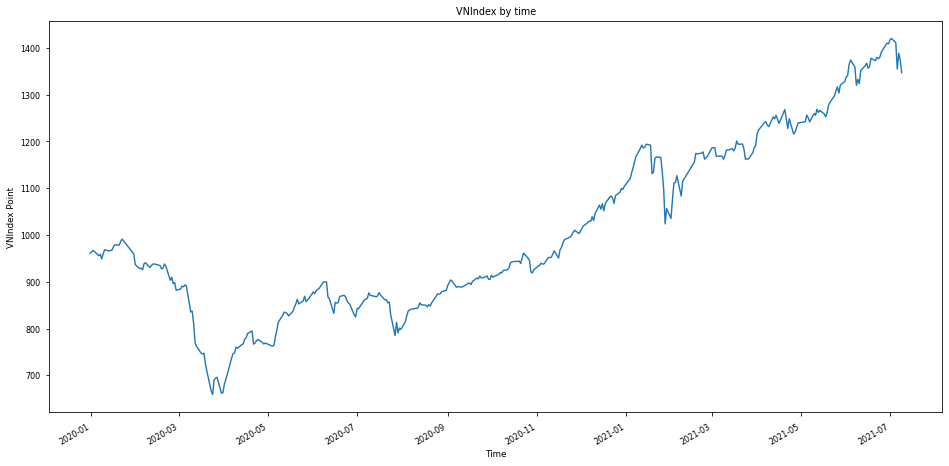

In [127]:
vnindex.plot(x='date', y='CloseFixed', xlabel='Time', ylabel='VNIndex Point', 
            title='VNIndex by time', legend=False, figsize=(16,8))

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

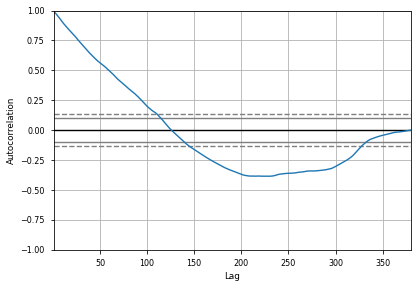

In [128]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(vnindex['CloseFixed'])

## ARIMA based model

In [129]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [130]:
# Data prepare

X = vnindex['CloseFixed']
train_size = int(len(X) * 0.8)
train, test = X[:train_size], X[train_size:len(X)]

# Convert series to list
train = [v for v in train]
test = [v for v in test]
prediction = list()

In [131]:
import warnings
warnings.filterwarnings("ignore")

In [132]:
def plot_evaluate(prediction, test):
    plt.plot(test, label='Real value')
    plt.plot(prediction, color='red', label='Predicted value')
    plt.legend()
    plt.show()

predicted=1043.956104, expected=773.910000
predicted=1043.070064, expected=768.920000
predicted=1042.174151, expected=766.840000
predicted=1041.277289, expected=794.970000
predicted=1040.477564, expected=789.600000
predicted=1039.665763, expected=780.700000
predicted=1038.830315, expected=777.220000
predicted=1037.989128, expected=767.410000
predicted=1037.121885, expected=765.790000
predicted=1036.255010, expected=757.940000
predicted=1035.368661, expected=760.330000
predicted=1034.495520, expected=748.020000
predicted=1033.588950, expected=746.690000
predicted=1032.683917, expected=736.750000
predicted=1031.753300, expected=701.800000
predicted=1030.718963, expected=680.230000
predicted=1029.623687, expected=662.530000
predicted=1028.480215, expected=662.260000
predicted=1027.342771, expected=696.060000
predicted=1026.317120, expected=694.210000
predicted=1025.292094, expected=690.250000
predicted=1024.261197, expected=659.210000
predicted=1023.141588, expected=666.590000
predicted=1

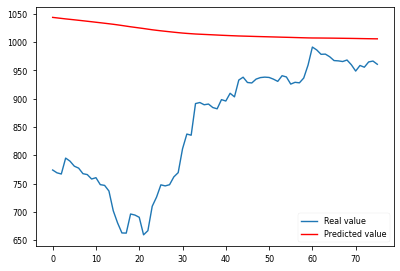

In [133]:
# Base ARIMA
for t in range(len(test)):
	model = ARIMA(train)
	model_fit = model.fit()
	output = model_fit.forecast()
	y = output[0]
	prediction.append(y)
	obs = test[t]
	train.append(obs)
	print('predicted=%f, expected=%f' % (y, obs))

# evaluate forecasts
rmse = mean_squared_error(y_true=test, y_pred=prediction, squared=False)
print('Test RMSE: %.3f' % rmse)

# plot forecasts against actual outcomes
plot_evaluate(prediction, test)

In [ ]:
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	rmse = sqrt(mean_squared_error(test, predictions))
	return rmse